# Computer Vision: Assignment 3 Part 1 - Some CNN Basics [50%]

Spring 2022 semester.

Due date: **July 1st 2022.**

## Introduction

This question is an introduction to using PyTorch for training simple neural net models. 

Two different datasets will be used: 
- MNIST digits [handwritten digits]
- CIFAR-10 [32x32 resolution color images of 10 object classes].

## Requirements

Perform this assignment in PyTorch, modifying the baseline code, producing outputs and adding required explanations - *all within this ipython notebook*.

Finally, submit this iPython notebook, including outputs, as an .ipynb file. 

## Question (1): Warmup [5%]

It is always good practice to visually inspect your data before trying to train a model, since it lets you check for problems and get a feel for the task at hand.

MNIST is a dataset of 70,000 grayscale hand-written digits (0 through 9).
60,000 of these are training images. 10,000 are a held out test set. 

CIFAR-10 is a dataset of 60,000 color images (32 by 32 resolution) across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck). 
The train/test split is 50k/10k.

**a)**  Use `matplotlib` and ipython notebook's visualization capabilities to display the average train and average test image of each class, for each of the two datasets.
[See this PyTorch tutorial page](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for hints on how to achieve this.

## Question (2): Training a Single Layer Network on MNIST [10%]

Start by running the training on MNIST. By default if you run this notebook successfully, it will train on MNIST.

This will initialize a single layer model train it on the 60,000 MNIST training images for 10 epochs (passes through the training data). 

The cross-entropy loss function computes a Logarithm of the Softmax on the output of the neural network, and then computes the negative log-likelihood w.r.t. the given target.

The default values for the learning rate, batch size and number of epochs are given in the "options" cell of this notebook. Unless otherwise specified, use the default values throughout this assignment. 

Note the decrease in training loss and corresponding decrease in validation errors.

**a)** Add code to plot out the network weights as images (one for each class, of size 28 by 28) after the last epoch. (Hint thread: [#1](https://discuss.pytorch.org/t/understanding-deep-network-visualize-weights/2060/2?u=smth) )

**b)** Reduce the number of training examples to just 50. [Hint: limit the iterator in the `train` function]. 
Paste the output into your report and explain what is happening to the model.

## Question (3): Training a Multi-Layer Network on MNIST [10%]

**a)**  Add an extra layer to the network with 1000 hidden units and a `tanh` non-linearity. [Hint: modify the `Net` class].

**b)**   Now retrain the model for 10 epochs with each of the learning rates in the set {0.01, 0.1, 1, 10} and test the resulting model. Create a figure and plot the loss curves of each of the four runs for comparison. Explain the obtained (train and test) results.

## Question (4): Training a Convolutional Network on CIFAR [15%]

To change over to the CIFAR-10 dataset, change the `options` cell's `dataset` variable to `'cifar10'`.

- Create a convolutional network with the following architecture:
  - Convolution with 5 by 5 filters, stride 2, 16 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - Convolution with 3 by 3 filters, (stride 1), 64 feature maps + Tanh nonlinearity.
  - 2 by 2 max pooling (non-overlapping).
  - Flatten to vector.
  - Linear layer with 64 hidden units + Tanh nonlinearity.
  - Linear layer to 10 output units.

**a)** Train it for 20 epochs on CIFAR-10 and plot the training loss curve (avg. loss per epoch) and final test loss and accuracy, when training with or without the two 3x3 convolutional layers. 

**b)**  Give a breakdown of the number of parameters (per layer) within the above model, as well as the overall number.

# **Answer (1):**
create needed blocks of code (and results) below

In [15]:
# imports
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib
from matplotlib.ticker import MaxNLocator

In [16]:
def imshow(img1, img2, dataset, label):
    img1 = img1 / 2 + 0.5  # un-normalize
    img2 = img2 / 2 + 0.5
    np_img1, np_img2 = img1.numpy(), img2.numpy()

    plt.figure()
    plt.suptitle(dataset + " dataset average: Class " + label)
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(np_img1, (1, 2, 0)))
    plt.title('Train')
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(np_img2, (1, 2, 0)))
    plt.title('Test')
    plt.show()

In [17]:
def show_average_images(train_loader, test_loader, dataset, labels):
    '''Plots the average image for each class in the dataset both for the training data and the test one'''
    
    train_counters, test_counters = [], []
    train_results, test_results = [], []
    
    for _ in range(len(labels)):
        train_counters.append(0)
        test_counters.append(0)
        train_results.append(None)
        test_results.append(None)
    
    dataiter = iter(train_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    train_counters[ind] += 1
                    if train_results[ind] is None:
                        train_results[ind] = img_temp
                    else:
                        train_results[ind] += img_temp

        except StopIteration:
            break

    dataiter = iter(test_loader)
    
    while True:
        try:
            img_temp, label_temp = dataiter.next()
            
            mn_value = torch.min(img_temp)
            mx_value = torch.max(img_temp)
            
            img_temp -= mn_value
            
            img_temp /= (mx_value - mn_value)
            
            for ind in range(len(labels)):
                if str(label_temp) == 'tensor([' + str(ind) + '])':
                    test_counters[ind] += 1
                    if test_results[ind] is None:
                        test_results[ind] = img_temp
                    else:
                        test_results[ind] += img_temp

        except StopIteration:
            break
    
    for index, label in enumerate(labels):
        
        test_results[index] /= test_counters[index]
        train_results[index] /= train_counters[index]

        imshow(torchvision.utils.make_grid(train_results[index]), torchvision.utils.make_grid(test_results[index]), 
               dataset, labels[index])

Files already downloaded and verified
Files already downloaded and verified


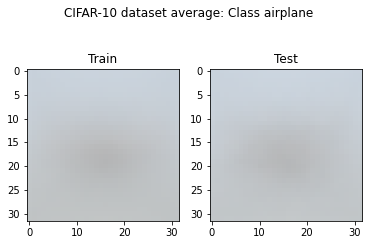

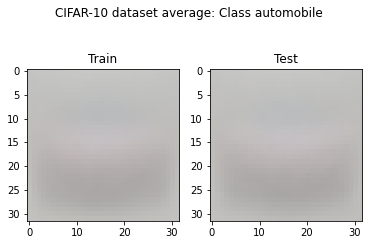

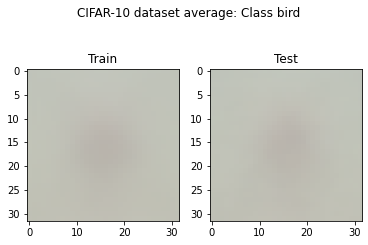

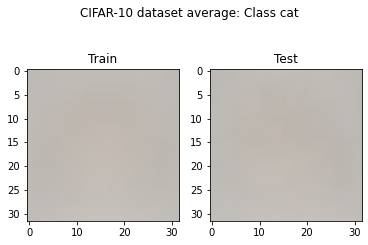

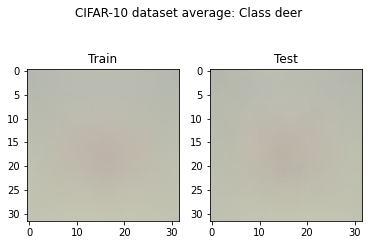

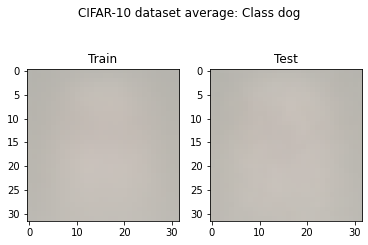

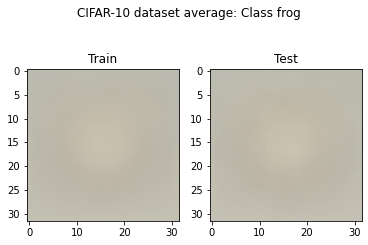

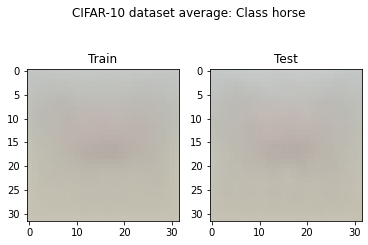

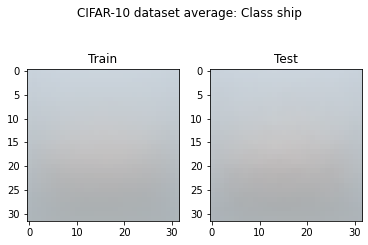

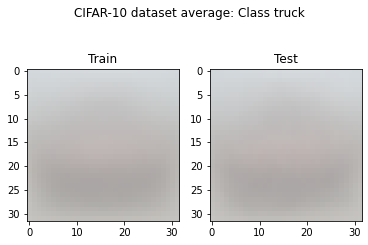

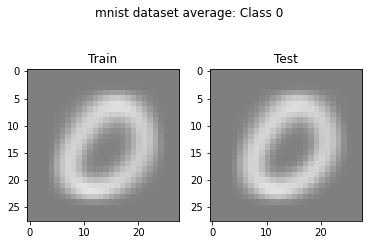

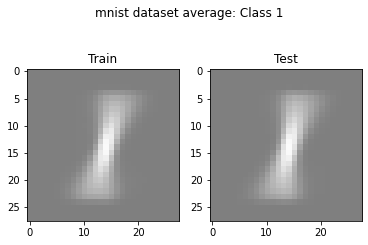

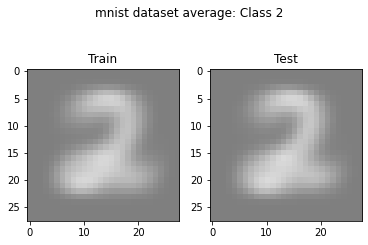

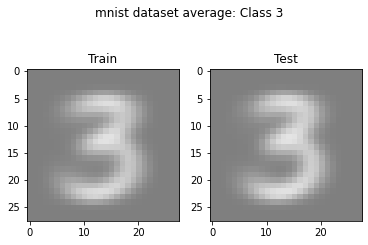

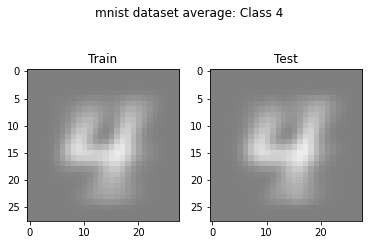

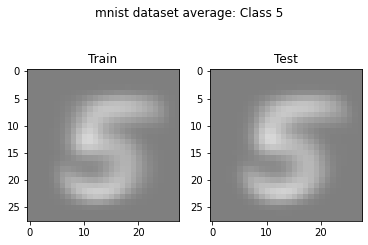

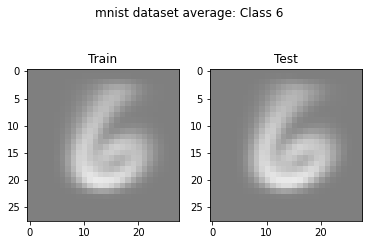

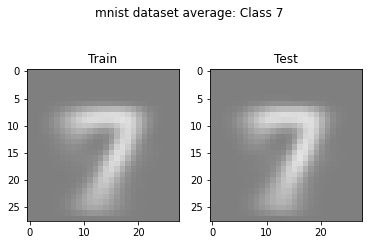

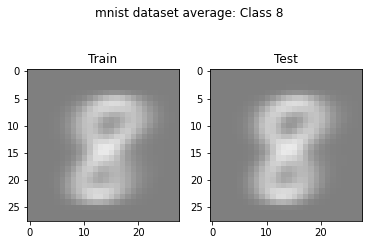

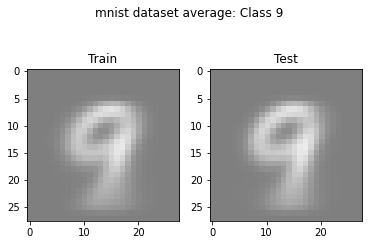

In [18]:
torch.utils.data.DataLoader.num_worker = 0

# building the transforms and data loaders

cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])

cifar_train = torchvision.datasets.CIFAR10(root='.', train=True,
                                           download=True, transform=cifar_transform)

cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

cifar_test = torchvision.datasets.CIFAR10(root='.', train=False,
                                          download=True, transform=cifar_transform)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=1,
                                                shuffle=False, num_workers=2)

mnist_train = torchvision.datasets.MNIST(root='.', train=True,
                                         download=True, transform=mnist_transform)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=1,
                                                 shuffle=True, num_workers=2)

mnist_test = torchvision.datasets.MNIST(root='.', train=False,
                                        download=True, transform=mnist_transform)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1,
                                                shuffle=False, num_workers=2)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
mnist_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

show_average_images(cifar_train_loader, cifar_test_loader, 'CIFAR-10', cifar_labels)
show_average_images(mnist_train_loader, mnist_test_loader, 'mnist', mnist_labels)

# **Answer (2):**
create needed blocks of code (and results) below

In [19]:
# options
dataset = 'mnist' # options: 'mnist' | 'cifar10'
batch_size = 64   # input batch size for training
epochs = 10       # number of epochs to train
lr = 0.01        # learning rate

In [20]:
## network and optimizer
if dataset == 'mnist':
    num_inputs = 784
elif dataset == 'cifar10':
    num_inputs = 3072

num_outputs = 10 # same for both CIFAR10 and MNIST, both have 10 classes as outputs

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, input):
        input = input.view(-1, num_inputs) # reshape input to batch x num_inputs
        output = self.linear(input)
        return output

network = Net(num_inputs, num_outputs)
optimizer = optim.SGD(network.parameters(), lr=lr)

In [21]:
# train and test functions
def train(epoch, train_loader):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(test_loader):
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [22]:
# Training and testing 
for i in range(1, epochs+1):
  train(i, mnist_train_loader)

# resetting the value of batch size in the DataLoader objects
cifar_train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

cifar_test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size,
                                                 shuffle=True, num_workers=2)

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size,
                                                shuffle=False, num_workers=2)

test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.696742
Train Epoch: 1 [100/60000 (0%)]	Loss: 5.672999
Train Epoch: 1 [200/60000 (0%)]	Loss: 0.045974
Train Epoch: 1 [300/60000 (0%)]	Loss: 0.276450
Train Epoch: 1 [400/60000 (1%)]	Loss: 0.014483
Train Epoch: 1 [500/60000 (1%)]	Loss: 0.112966
Train Epoch: 1 [600/60000 (1%)]	Loss: 0.097518
Train Epoch: 1 [700/60000 (1%)]	Loss: 0.024715
Train Epoch: 1 [800/60000 (1%)]	Loss: 0.000228
Train Epoch: 1 [900/60000 (2%)]	Loss: 1.618474
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.001958
Train Epoch: 1 [1100/60000 (2%)]	Loss: 0.000030
Train Epoch: 1 [1200/60000 (2%)]	Loss: 0.002054
Train Epoch: 1 [1300/60000 (2%)]	Loss: 0.039198
Train Epoch: 1 [1400/60000 (2%)]	Loss: 0.000334
Train Epoch: 1 [1500/60000 (2%)]	Loss: 0.000235
Train Epoch: 1 [1600/60000 (3%)]	Loss: 0.000469
Train Epoch: 1 [1700/60000 (3%)]	Loss: 0.200605
Train Epoch: 1 [1800/60000 (3%)]	Loss: 0.003729
Train Epoch: 1 [1900/60000 (3%)]	Loss: 0.202209
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.004323
Trai

Train Epoch: 1 [17100/60000 (28%)]	Loss: 0.000000
Train Epoch: 1 [17200/60000 (29%)]	Loss: 0.000014
Train Epoch: 1 [17300/60000 (29%)]	Loss: 0.013627
Train Epoch: 1 [17400/60000 (29%)]	Loss: 0.003692
Train Epoch: 1 [17500/60000 (29%)]	Loss: 0.001387
Train Epoch: 1 [17600/60000 (29%)]	Loss: 0.000867
Train Epoch: 1 [17700/60000 (30%)]	Loss: 0.000857
Train Epoch: 1 [17800/60000 (30%)]	Loss: 0.029934
Train Epoch: 1 [17900/60000 (30%)]	Loss: 0.001787
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.005687
Train Epoch: 1 [18100/60000 (30%)]	Loss: 0.014147
Train Epoch: 1 [18200/60000 (30%)]	Loss: 0.000018
Train Epoch: 1 [18300/60000 (30%)]	Loss: 0.000198
Train Epoch: 1 [18400/60000 (31%)]	Loss: 0.040290
Train Epoch: 1 [18500/60000 (31%)]	Loss: 0.021403
Train Epoch: 1 [18600/60000 (31%)]	Loss: 0.000000
Train Epoch: 1 [18700/60000 (31%)]	Loss: 0.002856
Train Epoch: 1 [18800/60000 (31%)]	Loss: 0.000023
Train Epoch: 1 [18900/60000 (32%)]	Loss: 0.095792
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.000070


Train Epoch: 1 [33700/60000 (56%)]	Loss: 0.086168
Train Epoch: 1 [33800/60000 (56%)]	Loss: 8.288079
Train Epoch: 1 [33900/60000 (56%)]	Loss: 0.003734
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.000000
Train Epoch: 1 [34100/60000 (57%)]	Loss: 2.804236
Train Epoch: 1 [34200/60000 (57%)]	Loss: 0.019707
Train Epoch: 1 [34300/60000 (57%)]	Loss: 0.000018
Train Epoch: 1 [34400/60000 (57%)]	Loss: 0.000002
Train Epoch: 1 [34500/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34600/60000 (58%)]	Loss: 0.063400
Train Epoch: 1 [34700/60000 (58%)]	Loss: 0.000333
Train Epoch: 1 [34800/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [34900/60000 (58%)]	Loss: 0.000000
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.000002
Train Epoch: 1 [35100/60000 (58%)]	Loss: 0.000007
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.000000
Train Epoch: 1 [35300/60000 (59%)]	Loss: 0.002913
Train Epoch: 1 [35400/60000 (59%)]	Loss: 0.000010
Train Epoch: 1 [35500/60000 (59%)]	Loss: 0.005586
Train Epoch: 1 [35600/60000 (59%)]	Loss: 0.000469


Train Epoch: 1 [50500/60000 (84%)]	Loss: 0.000000
Train Epoch: 1 [50600/60000 (84%)]	Loss: 0.000748
Train Epoch: 1 [50700/60000 (84%)]	Loss: 0.000001
Train Epoch: 1 [50800/60000 (85%)]	Loss: 1.014181
Train Epoch: 1 [50900/60000 (85%)]	Loss: 0.000155
Train Epoch: 1 [51000/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51100/60000 (85%)]	Loss: 0.000002
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000000
Train Epoch: 1 [51300/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51400/60000 (86%)]	Loss: 0.354053
Train Epoch: 1 [51500/60000 (86%)]	Loss: 12.653389
Train Epoch: 1 [51600/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [51700/60000 (86%)]	Loss: 1.614388
Train Epoch: 1 [51800/60000 (86%)]	Loss: 0.000013
Train Epoch: 1 [51900/60000 (86%)]	Loss: 0.000000
Train Epoch: 1 [52000/60000 (87%)]	Loss: 0.000000
Train Epoch: 1 [52100/60000 (87%)]	Loss: 0.044150
Train Epoch: 1 [52200/60000 (87%)]	Loss: 0.025643
Train Epoch: 1 [52300/60000 (87%)]	Loss: 0.000173
Train Epoch: 1 [52400/60000 (87%)]	Loss: 0.023231

Train Epoch: 2 [7500/60000 (12%)]	Loss: 0.000017
Train Epoch: 2 [7600/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [7700/60000 (13%)]	Loss: 0.000003
Train Epoch: 2 [7800/60000 (13%)]	Loss: 4.530274
Train Epoch: 2 [7900/60000 (13%)]	Loss: 0.000150
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.000000
Train Epoch: 2 [8100/60000 (14%)]	Loss: 0.000013
Train Epoch: 2 [8200/60000 (14%)]	Loss: 1.709852
Train Epoch: 2 [8300/60000 (14%)]	Loss: 0.001409
Train Epoch: 2 [8400/60000 (14%)]	Loss: 0.000200
Train Epoch: 2 [8500/60000 (14%)]	Loss: 0.000000
Train Epoch: 2 [8600/60000 (14%)]	Loss: 0.000002
Train Epoch: 2 [8700/60000 (14%)]	Loss: 0.000044
Train Epoch: 2 [8800/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [8900/60000 (15%)]	Loss: 0.000655
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9100/60000 (15%)]	Loss: 1.485274
Train Epoch: 2 [9200/60000 (15%)]	Loss: 0.000000
Train Epoch: 2 [9300/60000 (16%)]	Loss: 0.000574
Train Epoch: 2 [9400/60000 (16%)]	Loss: 0.000000
Train Epoch: 2 [9500

Train Epoch: 2 [24000/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24100/60000 (40%)]	Loss: 0.001454
Train Epoch: 2 [24200/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24300/60000 (40%)]	Loss: 0.000000
Train Epoch: 2 [24400/60000 (41%)]	Loss: 0.000057
Train Epoch: 2 [24500/60000 (41%)]	Loss: 0.000002
Train Epoch: 2 [24600/60000 (41%)]	Loss: 0.001849
Train Epoch: 2 [24700/60000 (41%)]	Loss: 0.000000
Train Epoch: 2 [24800/60000 (41%)]	Loss: 0.315133
Train Epoch: 2 [24900/60000 (42%)]	Loss: 0.004145
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.000004
Train Epoch: 2 [25100/60000 (42%)]	Loss: 0.000037
Train Epoch: 2 [25200/60000 (42%)]	Loss: 0.000016
Train Epoch: 2 [25300/60000 (42%)]	Loss: 0.000000
Train Epoch: 2 [25400/60000 (42%)]	Loss: 0.203470
Train Epoch: 2 [25500/60000 (42%)]	Loss: 0.001902
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.003203
Train Epoch: 2 [25700/60000 (43%)]	Loss: 0.000000
Train Epoch: 2 [25800/60000 (43%)]	Loss: 0.000001
Train Epoch: 2 [25900/60000 (43%)]	Loss: 0.005294


Train Epoch: 2 [40800/60000 (68%)]	Loss: 0.000010
Train Epoch: 2 [40900/60000 (68%)]	Loss: 0.097973
Train Epoch: 2 [41000/60000 (68%)]	Loss: 0.000000
Train Epoch: 2 [41100/60000 (68%)]	Loss: 0.000013
Train Epoch: 2 [41200/60000 (69%)]	Loss: 0.168986
Train Epoch: 2 [41300/60000 (69%)]	Loss: 2.743699
Train Epoch: 2 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 2 [41500/60000 (69%)]	Loss: 0.005964
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.001335
Train Epoch: 2 [41700/60000 (70%)]	Loss: 3.554598
Train Epoch: 2 [41800/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [41900/60000 (70%)]	Loss: 0.000067
Train Epoch: 2 [42000/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42100/60000 (70%)]	Loss: 1.783192
Train Epoch: 2 [42200/60000 (70%)]	Loss: 0.000000
Train Epoch: 2 [42300/60000 (70%)]	Loss: 0.000722
Train Epoch: 2 [42400/60000 (71%)]	Loss: 0.000000
Train Epoch: 2 [42500/60000 (71%)]	Loss: 0.580885
Train Epoch: 2 [42600/60000 (71%)]	Loss: 0.005340
Train Epoch: 2 [42700/60000 (71%)]	Loss: 0.000005


Train Epoch: 2 [57700/60000 (96%)]	Loss: 2.903376
Train Epoch: 2 [57800/60000 (96%)]	Loss: 0.000112
Train Epoch: 2 [57900/60000 (96%)]	Loss: 0.032038
Train Epoch: 2 [58000/60000 (97%)]	Loss: 0.000164
Train Epoch: 2 [58100/60000 (97%)]	Loss: 0.000095
Train Epoch: 2 [58200/60000 (97%)]	Loss: 0.000001
Train Epoch: 2 [58300/60000 (97%)]	Loss: 0.000002
Train Epoch: 2 [58400/60000 (97%)]	Loss: 0.000000
Train Epoch: 2 [58500/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [58600/60000 (98%)]	Loss: 0.000001
Train Epoch: 2 [58700/60000 (98%)]	Loss: 0.350486
Train Epoch: 2 [58800/60000 (98%)]	Loss: 0.012648
Train Epoch: 2 [58900/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [59000/60000 (98%)]	Loss: 0.000036
Train Epoch: 2 [59100/60000 (98%)]	Loss: 0.000000
Train Epoch: 2 [59200/60000 (99%)]	Loss: 0.001968
Train Epoch: 2 [59300/60000 (99%)]	Loss: 0.000425
Train Epoch: 2 [59400/60000 (99%)]	Loss: 0.001068
Train Epoch: 2 [59500/60000 (99%)]	Loss: 0.000025
Train Epoch: 2 [59600/60000 (99%)]	Loss: 0.000018


Train Epoch: 3 [14700/60000 (24%)]	Loss: 1.001345
Train Epoch: 3 [14800/60000 (25%)]	Loss: 0.002430
Train Epoch: 3 [14900/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.000000
Train Epoch: 3 [15100/60000 (25%)]	Loss: 0.000004
Train Epoch: 3 [15200/60000 (25%)]	Loss: 0.060105
Train Epoch: 3 [15300/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15400/60000 (26%)]	Loss: 0.015874
Train Epoch: 3 [15500/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15600/60000 (26%)]	Loss: 0.000002
Train Epoch: 3 [15700/60000 (26%)]	Loss: 0.010673
Train Epoch: 3 [15800/60000 (26%)]	Loss: 0.000000
Train Epoch: 3 [15900/60000 (26%)]	Loss: 0.310232
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.000000
Train Epoch: 3 [16100/60000 (27%)]	Loss: 0.000002
Train Epoch: 3 [16200/60000 (27%)]	Loss: 0.000000
Train Epoch: 3 [16300/60000 (27%)]	Loss: 0.000000
Train Epoch: 3 [16400/60000 (27%)]	Loss: 1.077672
Train Epoch: 3 [16500/60000 (28%)]	Loss: 0.000000
Train Epoch: 3 [16600/60000 (28%)]	Loss: 0.001346


Train Epoch: 3 [31200/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31300/60000 (52%)]	Loss: 11.364778
Train Epoch: 3 [31400/60000 (52%)]	Loss: 14.233503
Train Epoch: 3 [31500/60000 (52%)]	Loss: 0.000000
Train Epoch: 3 [31600/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31700/60000 (53%)]	Loss: 0.000000
Train Epoch: 3 [31800/60000 (53%)]	Loss: 0.021836
Train Epoch: 3 [31900/60000 (53%)]	Loss: 0.000038
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000001
Train Epoch: 3 [32100/60000 (54%)]	Loss: 0.002542
Train Epoch: 3 [32200/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32300/60000 (54%)]	Loss: 0.000001
Train Epoch: 3 [32400/60000 (54%)]	Loss: 0.279981
Train Epoch: 3 [32500/60000 (54%)]	Loss: 0.000002
Train Epoch: 3 [32600/60000 (54%)]	Loss: 0.000000
Train Epoch: 3 [32700/60000 (54%)]	Loss: 0.000059
Train Epoch: 3 [32800/60000 (55%)]	Loss: 0.009168
Train Epoch: 3 [32900/60000 (55%)]	Loss: 0.000005
Train Epoch: 3 [33000/60000 (55%)]	Loss: 0.000459
Train Epoch: 3 [33100/60000 (55%)]	Loss: 0.00000

Train Epoch: 3 [47900/60000 (80%)]	Loss: 0.000044
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.000000
Train Epoch: 3 [48100/60000 (80%)]	Loss: 0.000531
Train Epoch: 3 [48200/60000 (80%)]	Loss: 0.672988
Train Epoch: 3 [48300/60000 (80%)]	Loss: 0.000009
Train Epoch: 3 [48400/60000 (81%)]	Loss: 0.000008
Train Epoch: 3 [48500/60000 (81%)]	Loss: 0.000007
Train Epoch: 3 [48600/60000 (81%)]	Loss: 0.000026
Train Epoch: 3 [48700/60000 (81%)]	Loss: 0.000067
Train Epoch: 3 [48800/60000 (81%)]	Loss: 0.000079
Train Epoch: 3 [48900/60000 (82%)]	Loss: 0.017918
Train Epoch: 3 [49000/60000 (82%)]	Loss: 0.000620
Train Epoch: 3 [49100/60000 (82%)]	Loss: 0.000034
Train Epoch: 3 [49200/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49300/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49400/60000 (82%)]	Loss: 0.000000
Train Epoch: 3 [49500/60000 (82%)]	Loss: 0.000001
Train Epoch: 3 [49600/60000 (83%)]	Loss: 0.003058
Train Epoch: 3 [49700/60000 (83%)]	Loss: 0.025835
Train Epoch: 3 [49800/60000 (83%)]	Loss: 0.000000


Train Epoch: 4 [4700/60000 (8%)]	Loss: 0.000217
Train Epoch: 4 [4800/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [4900/60000 (8%)]	Loss: 0.000036
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.002140
Train Epoch: 4 [5100/60000 (8%)]	Loss: 0.000000
Train Epoch: 4 [5200/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5300/60000 (9%)]	Loss: 1.611576
Train Epoch: 4 [5400/60000 (9%)]	Loss: 0.000000
Train Epoch: 4 [5500/60000 (9%)]	Loss: 11.124468
Train Epoch: 4 [5600/60000 (9%)]	Loss: 0.300274
Train Epoch: 4 [5700/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [5800/60000 (10%)]	Loss: 0.031180
Train Epoch: 4 [5900/60000 (10%)]	Loss: 0.000144
Train Epoch: 4 [6000/60000 (10%)]	Loss: 0.006477
Train Epoch: 4 [6100/60000 (10%)]	Loss: 0.000033
Train Epoch: 4 [6200/60000 (10%)]	Loss: 6.406999
Train Epoch: 4 [6300/60000 (10%)]	Loss: 0.000000
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.633530
Train Epoch: 4 [6500/60000 (11%)]	Loss: 8.499330
Train Epoch: 4 [6600/60000 (11%)]	Loss: 0.001844
Train Epoch: 4 [6700/60000 (1

Train Epoch: 4 [21400/60000 (36%)]	Loss: 0.000000
Train Epoch: 4 [21500/60000 (36%)]	Loss: 10.339370
Train Epoch: 4 [21600/60000 (36%)]	Loss: 9.318870
Train Epoch: 4 [21700/60000 (36%)]	Loss: 0.000175
Train Epoch: 4 [21800/60000 (36%)]	Loss: 12.776118
Train Epoch: 4 [21900/60000 (36%)]	Loss: 0.002529
Train Epoch: 4 [22000/60000 (37%)]	Loss: 0.000000
Train Epoch: 4 [22100/60000 (37%)]	Loss: 0.000201
Train Epoch: 4 [22200/60000 (37%)]	Loss: 0.016845
Train Epoch: 4 [22300/60000 (37%)]	Loss: 0.251897
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.001598
Train Epoch: 4 [22500/60000 (38%)]	Loss: 0.254037
Train Epoch: 4 [22600/60000 (38%)]	Loss: 0.007937
Train Epoch: 4 [22700/60000 (38%)]	Loss: 0.000030
Train Epoch: 4 [22800/60000 (38%)]	Loss: 2.137337
Train Epoch: 4 [22900/60000 (38%)]	Loss: 0.000000
Train Epoch: 4 [23000/60000 (38%)]	Loss: 0.001387
Train Epoch: 4 [23100/60000 (38%)]	Loss: 0.000004
Train Epoch: 4 [23200/60000 (39%)]	Loss: 0.000033
Train Epoch: 4 [23300/60000 (39%)]	Loss: 0.01116

Train Epoch: 4 [38000/60000 (63%)]	Loss: 0.000000
Train Epoch: 4 [38100/60000 (64%)]	Loss: 0.028505
Train Epoch: 4 [38200/60000 (64%)]	Loss: 0.000000
Train Epoch: 4 [38300/60000 (64%)]	Loss: 0.000007
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000068
Train Epoch: 4 [38500/60000 (64%)]	Loss: 0.000320
Train Epoch: 4 [38600/60000 (64%)]	Loss: 0.000035
Train Epoch: 4 [38700/60000 (64%)]	Loss: 0.000001
Train Epoch: 4 [38800/60000 (65%)]	Loss: 0.000000
Train Epoch: 4 [38900/60000 (65%)]	Loss: 0.288751
Train Epoch: 4 [39000/60000 (65%)]	Loss: 0.438136
Train Epoch: 4 [39100/60000 (65%)]	Loss: 2.041167
Train Epoch: 4 [39200/60000 (65%)]	Loss: 0.002403
Train Epoch: 4 [39300/60000 (66%)]	Loss: 3.145869
Train Epoch: 4 [39400/60000 (66%)]	Loss: 0.000019
Train Epoch: 4 [39500/60000 (66%)]	Loss: 0.000026
Train Epoch: 4 [39600/60000 (66%)]	Loss: 0.017428
Train Epoch: 4 [39700/60000 (66%)]	Loss: 0.000436
Train Epoch: 4 [39800/60000 (66%)]	Loss: 0.559070
Train Epoch: 4 [39900/60000 (66%)]	Loss: 0.000054


Train Epoch: 4 [54600/60000 (91%)]	Loss: 0.018582
Train Epoch: 4 [54700/60000 (91%)]	Loss: 0.000030
Train Epoch: 4 [54800/60000 (91%)]	Loss: 0.000000
Train Epoch: 4 [54900/60000 (92%)]	Loss: 0.001197
Train Epoch: 4 [55000/60000 (92%)]	Loss: 0.006612
Train Epoch: 4 [55100/60000 (92%)]	Loss: 0.000002
Train Epoch: 4 [55200/60000 (92%)]	Loss: 0.002622
Train Epoch: 4 [55300/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55400/60000 (92%)]	Loss: 0.005682
Train Epoch: 4 [55500/60000 (92%)]	Loss: 0.000000
Train Epoch: 4 [55600/60000 (93%)]	Loss: 0.000003
Train Epoch: 4 [55700/60000 (93%)]	Loss: 0.000134
Train Epoch: 4 [55800/60000 (93%)]	Loss: 0.000000
Train Epoch: 4 [55900/60000 (93%)]	Loss: 0.000004
Train Epoch: 4 [56000/60000 (93%)]	Loss: 0.000002
Train Epoch: 4 [56100/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56200/60000 (94%)]	Loss: 0.000072
Train Epoch: 4 [56300/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56400/60000 (94%)]	Loss: 0.000000
Train Epoch: 4 [56500/60000 (94%)]	Loss: 0.000763


Train Epoch: 5 [11500/60000 (19%)]	Loss: 0.000000
Train Epoch: 5 [11600/60000 (19%)]	Loss: 0.002875
Train Epoch: 5 [11700/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [11800/60000 (20%)]	Loss: 1.316414
Train Epoch: 5 [11900/60000 (20%)]	Loss: 0.002888
Train Epoch: 5 [12000/60000 (20%)]	Loss: 0.000017
Train Epoch: 5 [12100/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12200/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12300/60000 (20%)]	Loss: 0.000000
Train Epoch: 5 [12400/60000 (21%)]	Loss: 0.104748
Train Epoch: 5 [12500/60000 (21%)]	Loss: 0.050921
Train Epoch: 5 [12600/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12700/60000 (21%)]	Loss: 0.000020
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000000
Train Epoch: 5 [12900/60000 (22%)]	Loss: 0.000043
Train Epoch: 5 [13000/60000 (22%)]	Loss: 0.000001
Train Epoch: 5 [13100/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13200/60000 (22%)]	Loss: 0.004548
Train Epoch: 5 [13300/60000 (22%)]	Loss: 0.000000
Train Epoch: 5 [13400/60000 (22%)]	Loss: 0.000000


Train Epoch: 5 [28400/60000 (47%)]	Loss: 0.000484
Train Epoch: 5 [28500/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28600/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [28700/60000 (48%)]	Loss: 2.424667
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.002039
Train Epoch: 5 [28900/60000 (48%)]	Loss: 0.000000
Train Epoch: 5 [29000/60000 (48%)]	Loss: 0.000142
Train Epoch: 5 [29100/60000 (48%)]	Loss: 1.999841
Train Epoch: 5 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29300/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29400/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29600/60000 (49%)]	Loss: 0.000000
Train Epoch: 5 [29700/60000 (50%)]	Loss: 0.000001
Train Epoch: 5 [29800/60000 (50%)]	Loss: 0.000002
Train Epoch: 5 [29900/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30000/60000 (50%)]	Loss: 25.938501
Train Epoch: 5 [30100/60000 (50%)]	Loss: 0.000000
Train Epoch: 5 [30200/60000 (50%)]	Loss: 0.000002
Train Epoch: 5 [30300/60000 (50%)]	Loss: 0.001410

Train Epoch: 5 [45300/60000 (76%)]	Loss: 0.000002
Train Epoch: 5 [45400/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45500/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45600/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [45700/60000 (76%)]	Loss: 1.560894
Train Epoch: 5 [45800/60000 (76%)]	Loss: 0.000804
Train Epoch: 5 [45900/60000 (76%)]	Loss: 0.000000
Train Epoch: 5 [46000/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46100/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46200/60000 (77%)]	Loss: 0.000961
Train Epoch: 5 [46300/60000 (77%)]	Loss: 0.304075
Train Epoch: 5 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 5 [46500/60000 (78%)]	Loss: 0.075476
Train Epoch: 5 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46700/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46800/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [46900/60000 (78%)]	Loss: 0.074386
Train Epoch: 5 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 5 [47100/60000 (78%)]	Loss: 0.002832
Train Epoch: 5 [47200/60000 (79%)]	Loss: 0.003576


Train Epoch: 6 [2100/60000 (4%)]	Loss: 0.000002
Train Epoch: 6 [2200/60000 (4%)]	Loss: 0.003983
Train Epoch: 6 [2300/60000 (4%)]	Loss: 0.010552
Train Epoch: 6 [2400/60000 (4%)]	Loss: 0.000000
Train Epoch: 6 [2500/60000 (4%)]	Loss: 0.000417
Train Epoch: 6 [2600/60000 (4%)]	Loss: 0.002572
Train Epoch: 6 [2700/60000 (4%)]	Loss: 0.000002
Train Epoch: 6 [2800/60000 (5%)]	Loss: 0.000003
Train Epoch: 6 [2900/60000 (5%)]	Loss: 0.000164
Train Epoch: 6 [3000/60000 (5%)]	Loss: 0.049371
Train Epoch: 6 [3100/60000 (5%)]	Loss: 17.083973
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.000000
Train Epoch: 6 [3300/60000 (6%)]	Loss: 0.000003
Train Epoch: 6 [3400/60000 (6%)]	Loss: 0.000140
Train Epoch: 6 [3500/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3600/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3700/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3800/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [3900/60000 (6%)]	Loss: 0.000000
Train Epoch: 6 [4000/60000 (7%)]	Loss: 0.000015
Train Epoch: 6 [4100/60000 (7%)]	Loss: 

Train Epoch: 6 [19100/60000 (32%)]	Loss: 0.000048
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.001887
Train Epoch: 6 [19300/60000 (32%)]	Loss: 0.000007
Train Epoch: 6 [19400/60000 (32%)]	Loss: 0.000000
Train Epoch: 6 [19500/60000 (32%)]	Loss: 0.000002
Train Epoch: 6 [19600/60000 (33%)]	Loss: 0.099940
Train Epoch: 6 [19700/60000 (33%)]	Loss: 0.000591
Train Epoch: 6 [19800/60000 (33%)]	Loss: 0.000574
Train Epoch: 6 [19900/60000 (33%)]	Loss: 0.000004
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.000030
Train Epoch: 6 [20100/60000 (34%)]	Loss: 0.000027
Train Epoch: 6 [20200/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20300/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20400/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20500/60000 (34%)]	Loss: 0.000001
Train Epoch: 6 [20600/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20700/60000 (34%)]	Loss: 0.000000
Train Epoch: 6 [20800/60000 (35%)]	Loss: 0.000000
Train Epoch: 6 [20900/60000 (35%)]	Loss: 0.000547
Train Epoch: 6 [21000/60000 (35%)]	Loss: 0.000203


Train Epoch: 6 [35800/60000 (60%)]	Loss: 0.000172
Train Epoch: 6 [35900/60000 (60%)]	Loss: 0.018524
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36100/60000 (60%)]	Loss: 0.000515
Train Epoch: 6 [36200/60000 (60%)]	Loss: 0.000000
Train Epoch: 6 [36300/60000 (60%)]	Loss: 0.000001
Train Epoch: 6 [36400/60000 (61%)]	Loss: 0.000001
Train Epoch: 6 [36500/60000 (61%)]	Loss: 0.001343
Train Epoch: 6 [36600/60000 (61%)]	Loss: 3.889692
Train Epoch: 6 [36700/60000 (61%)]	Loss: 0.001504
Train Epoch: 6 [36800/60000 (61%)]	Loss: 0.000000
Train Epoch: 6 [36900/60000 (62%)]	Loss: 0.000799
Train Epoch: 6 [37000/60000 (62%)]	Loss: 0.017924
Train Epoch: 6 [37100/60000 (62%)]	Loss: 0.000000
Train Epoch: 6 [37200/60000 (62%)]	Loss: 0.300096
Train Epoch: 6 [37300/60000 (62%)]	Loss: 0.220166
Train Epoch: 6 [37400/60000 (62%)]	Loss: 0.000002
Train Epoch: 6 [37500/60000 (62%)]	Loss: 0.000305
Train Epoch: 6 [37600/60000 (63%)]	Loss: 0.000001
Train Epoch: 6 [37700/60000 (63%)]	Loss: 0.160100


Train Epoch: 6 [52400/60000 (87%)]	Loss: 0.000001
Train Epoch: 6 [52500/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52600/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [52700/60000 (88%)]	Loss: 0.000235
Train Epoch: 6 [52800/60000 (88%)]	Loss: 0.001112
Train Epoch: 6 [52900/60000 (88%)]	Loss: 0.000000
Train Epoch: 6 [53000/60000 (88%)]	Loss: 0.079660
Train Epoch: 6 [53100/60000 (88%)]	Loss: 0.019077
Train Epoch: 6 [53200/60000 (89%)]	Loss: 0.000000
Train Epoch: 6 [53300/60000 (89%)]	Loss: 0.016499
Train Epoch: 6 [53400/60000 (89%)]	Loss: 0.089823
Train Epoch: 6 [53500/60000 (89%)]	Loss: 4.220910
Train Epoch: 6 [53600/60000 (89%)]	Loss: 0.000002
Train Epoch: 6 [53700/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [53800/60000 (90%)]	Loss: 11.869697
Train Epoch: 6 [53900/60000 (90%)]	Loss: 0.001716
Train Epoch: 6 [54000/60000 (90%)]	Loss: 0.000000
Train Epoch: 6 [54100/60000 (90%)]	Loss: 0.000001
Train Epoch: 6 [54200/60000 (90%)]	Loss: 0.000001
Train Epoch: 6 [54300/60000 (90%)]	Loss: 0.000005

Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9700/60000 (16%)]	Loss: 0.000000
Train Epoch: 7 [9800/60000 (16%)]	Loss: 0.000016
Train Epoch: 7 [9900/60000 (16%)]	Loss: 0.969653
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10100/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10200/60000 (17%)]	Loss: 0.000188
Train Epoch: 7 [10300/60000 (17%)]	Loss: 0.000000
Train Epoch: 7 [10400/60000 (17%)]	Loss: 3.302579
Train Epoch: 7 [10500/60000 (18%)]	Loss: 0.000001
Train Epoch: 7 [10600/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10700/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10800/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [10900/60000 (18%)]	Loss: 0.006710
Train Epoch: 7 [11000/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11100/60000 (18%)]	Loss: 0.000000
Train Epoch: 7 [11200/60000 (19%)]	Loss: 0.000000
Train Epoch: 7 [11300/60000 (19%)]	Loss: 0.015385
Train Epoch: 7 [11400/60000 (19%)]	Loss: 0.000020
Train Epoch: 7 [11500/60000 (19%)]	Loss: 0.000014
Trai

Train Epoch: 7 [26000/60000 (43%)]	Loss: 5.069599
Train Epoch: 7 [26100/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26200/60000 (44%)]	Loss: 0.001136
Train Epoch: 7 [26300/60000 (44%)]	Loss: 0.000002
Train Epoch: 7 [26400/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26500/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26600/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26700/60000 (44%)]	Loss: 0.000000
Train Epoch: 7 [26800/60000 (45%)]	Loss: 0.000194
Train Epoch: 7 [26900/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27000/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27100/60000 (45%)]	Loss: 0.000008
Train Epoch: 7 [27200/60000 (45%)]	Loss: 0.000000
Train Epoch: 7 [27300/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27400/60000 (46%)]	Loss: 0.000006
Train Epoch: 7 [27500/60000 (46%)]	Loss: 0.000190
Train Epoch: 7 [27600/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27700/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27800/60000 (46%)]	Loss: 0.000000
Train Epoch: 7 [27900/60000 (46%)]	Loss: 0.000000


Train Epoch: 7 [42700/60000 (71%)]	Loss: 0.018316
Train Epoch: 7 [42800/60000 (71%)]	Loss: 0.000029
Train Epoch: 7 [42900/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43000/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43100/60000 (72%)]	Loss: 0.001223
Train Epoch: 7 [43200/60000 (72%)]	Loss: 0.000001
Train Epoch: 7 [43300/60000 (72%)]	Loss: 1.137349
Train Epoch: 7 [43400/60000 (72%)]	Loss: 0.000048
Train Epoch: 7 [43500/60000 (72%)]	Loss: 0.000000
Train Epoch: 7 [43600/60000 (73%)]	Loss: 1.461397
Train Epoch: 7 [43700/60000 (73%)]	Loss: 0.000000
Train Epoch: 7 [43800/60000 (73%)]	Loss: 1.166579
Train Epoch: 7 [43900/60000 (73%)]	Loss: 0.000005
Train Epoch: 7 [44000/60000 (73%)]	Loss: 0.012341
Train Epoch: 7 [44100/60000 (74%)]	Loss: 1.268818
Train Epoch: 7 [44200/60000 (74%)]	Loss: 0.000316
Train Epoch: 7 [44300/60000 (74%)]	Loss: 0.000000
Train Epoch: 7 [44400/60000 (74%)]	Loss: 6.998862
Train Epoch: 7 [44500/60000 (74%)]	Loss: 0.002368
Train Epoch: 7 [44600/60000 (74%)]	Loss: 0.000000


Train Epoch: 7 [59300/60000 (99%)]	Loss: 0.094978
Train Epoch: 7 [59400/60000 (99%)]	Loss: 9.592876
Train Epoch: 7 [59500/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59600/60000 (99%)]	Loss: 0.000000
Train Epoch: 7 [59700/60000 (100%)]	Loss: 21.369610
Train Epoch: 7 [59800/60000 (100%)]	Loss: 0.000000
Train Epoch: 7 [59900/60000 (100%)]	Loss: 0.000000
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.001167
Train Epoch: 8 [100/60000 (0%)]	Loss: 0.000040
Train Epoch: 8 [200/60000 (0%)]	Loss: 0.003553
Train Epoch: 8 [300/60000 (0%)]	Loss: 0.000244
Train Epoch: 8 [400/60000 (1%)]	Loss: 0.011485
Train Epoch: 8 [500/60000 (1%)]	Loss: 0.000000
Train Epoch: 8 [600/60000 (1%)]	Loss: 0.004173
Train Epoch: 8 [700/60000 (1%)]	Loss: 0.000019
Train Epoch: 8 [800/60000 (1%)]	Loss: 0.000178
Train Epoch: 8 [900/60000 (2%)]	Loss: 0.010558
Train Epoch: 8 [1000/60000 (2%)]	Loss: 0.000080
Train Epoch: 8 [1100/60000 (2%)]	Loss: 0.001048
Train Epoch: 8 [1200/60000 (2%)]	Loss: 0.008717
Train Epoch: 8 [1300/60000 (2%)]	L

Train Epoch: 8 [16200/60000 (27%)]	Loss: 0.000009
Train Epoch: 8 [16300/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16400/60000 (27%)]	Loss: 0.000000
Train Epoch: 8 [16500/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16600/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [16700/60000 (28%)]	Loss: 0.000091
Train Epoch: 8 [16800/60000 (28%)]	Loss: 0.000002
Train Epoch: 8 [16900/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17000/60000 (28%)]	Loss: 0.000024
Train Epoch: 8 [17100/60000 (28%)]	Loss: 0.000000
Train Epoch: 8 [17200/60000 (29%)]	Loss: 4.618976
Train Epoch: 8 [17300/60000 (29%)]	Loss: 0.000000
Train Epoch: 8 [17400/60000 (29%)]	Loss: 0.023530
Train Epoch: 8 [17500/60000 (29%)]	Loss: 0.000155
Train Epoch: 8 [17600/60000 (29%)]	Loss: 0.000994
Train Epoch: 8 [17700/60000 (30%)]	Loss: 0.000496
Train Epoch: 8 [17800/60000 (30%)]	Loss: 0.000154
Train Epoch: 8 [17900/60000 (30%)]	Loss: 4.569218
Train Epoch: 8 [18000/60000 (30%)]	Loss: 0.005739
Train Epoch: 8 [18100/60000 (30%)]	Loss: 0.000000


Train Epoch: 8 [32900/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33000/60000 (55%)]	Loss: 1.833275
Train Epoch: 8 [33100/60000 (55%)]	Loss: 0.000000
Train Epoch: 8 [33200/60000 (55%)]	Loss: 0.000090
Train Epoch: 8 [33300/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33400/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33500/60000 (56%)]	Loss: 0.004007
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33700/60000 (56%)]	Loss: 0.000112
Train Epoch: 8 [33800/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [33900/60000 (56%)]	Loss: 0.000000
Train Epoch: 8 [34000/60000 (57%)]	Loss: 0.000320
Train Epoch: 8 [34100/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34200/60000 (57%)]	Loss: 0.000000
Train Epoch: 8 [34300/60000 (57%)]	Loss: 0.011269
Train Epoch: 8 [34400/60000 (57%)]	Loss: 0.003817
Train Epoch: 8 [34500/60000 (58%)]	Loss: 0.000026
Train Epoch: 8 [34600/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [34700/60000 (58%)]	Loss: 0.000000
Train Epoch: 8 [34800/60000 (58%)]	Loss: 0.000000


Train Epoch: 8 [49300/60000 (82%)]	Loss: 0.000026
Train Epoch: 8 [49400/60000 (82%)]	Loss: 0.000643
Train Epoch: 8 [49500/60000 (82%)]	Loss: 0.002451
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.000267
Train Epoch: 8 [49700/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [49800/60000 (83%)]	Loss: 0.000003
Train Epoch: 8 [49900/60000 (83%)]	Loss: 0.000000
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.001201
Train Epoch: 8 [50100/60000 (84%)]	Loss: 0.000013
Train Epoch: 8 [50200/60000 (84%)]	Loss: 0.000254
Train Epoch: 8 [50300/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50400/60000 (84%)]	Loss: 0.000007
Train Epoch: 8 [50500/60000 (84%)]	Loss: 0.008332
Train Epoch: 8 [50600/60000 (84%)]	Loss: 0.000004
Train Epoch: 8 [50700/60000 (84%)]	Loss: 0.000000
Train Epoch: 8 [50800/60000 (85%)]	Loss: 0.001621
Train Epoch: 8 [50900/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51000/60000 (85%)]	Loss: 0.000000
Train Epoch: 8 [51100/60000 (85%)]	Loss: 0.000227
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000000


Train Epoch: 9 [6500/60000 (11%)]	Loss: 3.540033
Train Epoch: 9 [6600/60000 (11%)]	Loss: 0.000005
Train Epoch: 9 [6700/60000 (11%)]	Loss: 0.002180
Train Epoch: 9 [6800/60000 (11%)]	Loss: 0.000000
Train Epoch: 9 [6900/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7000/60000 (12%)]	Loss: 0.000000
Train Epoch: 9 [7100/60000 (12%)]	Loss: 0.000073
Train Epoch: 9 [7200/60000 (12%)]	Loss: 1.815650
Train Epoch: 9 [7300/60000 (12%)]	Loss: 7.720834
Train Epoch: 9 [7400/60000 (12%)]	Loss: 0.007528
Train Epoch: 9 [7500/60000 (12%)]	Loss: 0.000482
Train Epoch: 9 [7600/60000 (13%)]	Loss: 22.723330
Train Epoch: 9 [7700/60000 (13%)]	Loss: 0.000008
Train Epoch: 9 [7800/60000 (13%)]	Loss: 0.000002
Train Epoch: 9 [7900/60000 (13%)]	Loss: 0.000000
Train Epoch: 9 [8000/60000 (13%)]	Loss: 0.023721
Train Epoch: 9 [8100/60000 (14%)]	Loss: 0.000019
Train Epoch: 9 [8200/60000 (14%)]	Loss: 0.000038
Train Epoch: 9 [8300/60000 (14%)]	Loss: 0.000001
Train Epoch: 9 [8400/60000 (14%)]	Loss: 0.000000
Train Epoch: 9 [850

Train Epoch: 9 [23200/60000 (39%)]	Loss: 22.978298
Train Epoch: 9 [23300/60000 (39%)]	Loss: 0.000100
Train Epoch: 9 [23400/60000 (39%)]	Loss: 0.008188
Train Epoch: 9 [23500/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23600/60000 (39%)]	Loss: 0.000000
Train Epoch: 9 [23700/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [23800/60000 (40%)]	Loss: 0.000001
Train Epoch: 9 [23900/60000 (40%)]	Loss: 0.001945
Train Epoch: 9 [24000/60000 (40%)]	Loss: 0.088636
Train Epoch: 9 [24100/60000 (40%)]	Loss: 0.000000
Train Epoch: 9 [24200/60000 (40%)]	Loss: 0.338814
Train Epoch: 9 [24300/60000 (40%)]	Loss: 0.000059
Train Epoch: 9 [24400/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24500/60000 (41%)]	Loss: 0.000104
Train Epoch: 9 [24600/60000 (41%)]	Loss: 0.000000
Train Epoch: 9 [24700/60000 (41%)]	Loss: 7.294268
Train Epoch: 9 [24800/60000 (41%)]	Loss: 0.003527
Train Epoch: 9 [24900/60000 (42%)]	Loss: 0.000000
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.000002
Train Epoch: 9 [25100/60000 (42%)]	Loss: 0.000000

Train Epoch: 9 [39600/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39700/60000 (66%)]	Loss: 0.254987
Train Epoch: 9 [39800/60000 (66%)]	Loss: 0.000000
Train Epoch: 9 [39900/60000 (66%)]	Loss: 0.016165
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.096501
Train Epoch: 9 [40100/60000 (67%)]	Loss: 0.465990
Train Epoch: 9 [40200/60000 (67%)]	Loss: 0.000000
Train Epoch: 9 [40300/60000 (67%)]	Loss: 0.000001
Train Epoch: 9 [40400/60000 (67%)]	Loss: 0.000010
Train Epoch: 9 [40500/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40600/60000 (68%)]	Loss: 0.000002
Train Epoch: 9 [40700/60000 (68%)]	Loss: 0.000001
Train Epoch: 9 [40800/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [40900/60000 (68%)]	Loss: 0.000000
Train Epoch: 9 [41000/60000 (68%)]	Loss: 0.000015
Train Epoch: 9 [41100/60000 (68%)]	Loss: 0.017952
Train Epoch: 9 [41200/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41300/60000 (69%)]	Loss: 3.927365
Train Epoch: 9 [41400/60000 (69%)]	Loss: 0.000000
Train Epoch: 9 [41500/60000 (69%)]	Loss: 0.000000


Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.009464
Train Epoch: 9 [56100/60000 (94%)]	Loss: 0.000151
Train Epoch: 9 [56200/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56300/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56400/60000 (94%)]	Loss: 0.000054
Train Epoch: 9 [56500/60000 (94%)]	Loss: 14.325171
Train Epoch: 9 [56600/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56700/60000 (94%)]	Loss: 0.000000
Train Epoch: 9 [56800/60000 (95%)]	Loss: 1.010214
Train Epoch: 9 [56900/60000 (95%)]	Loss: 3.685384
Train Epoch: 9 [57000/60000 (95%)]	Loss: 0.000664
Train Epoch: 9 [57100/60000 (95%)]	Loss: 0.115716
Train Epoch: 9 [57200/60000 (95%)]	Loss: 25.365917
Train Epoch: 9 [57300/60000 (96%)]	Loss: 0.000162
Train Epoch: 9 [57400/60000 (96%)]	Loss: 0.012804
Train Epoch: 9 [57500/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000085
Train Epoch: 9 [57700/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57800/60000 (96%)]	Loss: 0.000000
Train Epoch: 9 [57900/60000 (96%)]	Loss: 0.00238

Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000001
Train Epoch: 10 [12900/60000 (22%)]	Loss: 0.000600
Train Epoch: 10 [13000/60000 (22%)]	Loss: 0.000018
Train Epoch: 10 [13100/60000 (22%)]	Loss: 0.000000
Train Epoch: 10 [13200/60000 (22%)]	Loss: 0.000003
Train Epoch: 10 [13300/60000 (22%)]	Loss: 12.970612
Train Epoch: 10 [13400/60000 (22%)]	Loss: 0.006376
Train Epoch: 10 [13500/60000 (22%)]	Loss: 0.003212
Train Epoch: 10 [13600/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13700/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13800/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [13900/60000 (23%)]	Loss: 8.937679
Train Epoch: 10 [14000/60000 (23%)]	Loss: 0.000000
Train Epoch: 10 [14100/60000 (24%)]	Loss: 0.000006
Train Epoch: 10 [14200/60000 (24%)]	Loss: 0.028982
Train Epoch: 10 [14300/60000 (24%)]	Loss: 14.077746
Train Epoch: 10 [14400/60000 (24%)]	Loss: 0.000000
Train Epoch: 10 [14500/60000 (24%)]	Loss: 0.000081
Train Epoch: 10 [14600/60000 (24%)]	Loss: 0.000003
Train Epoch: 10 [14700/60000 

Train Epoch: 10 [28900/60000 (48%)]	Loss: 14.960606
Train Epoch: 10 [29000/60000 (48%)]	Loss: 0.000000
Train Epoch: 10 [29100/60000 (48%)]	Loss: 0.000643
Train Epoch: 10 [29200/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29300/60000 (49%)]	Loss: 0.063381
Train Epoch: 10 [29400/60000 (49%)]	Loss: 0.040865
Train Epoch: 10 [29500/60000 (49%)]	Loss: 0.000000
Train Epoch: 10 [29600/60000 (49%)]	Loss: 0.001234
Train Epoch: 10 [29700/60000 (50%)]	Loss: 1.133240
Train Epoch: 10 [29800/60000 (50%)]	Loss: 0.000005
Train Epoch: 10 [29900/60000 (50%)]	Loss: 0.000158
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.699940
Train Epoch: 10 [30100/60000 (50%)]	Loss: 3.298734
Train Epoch: 10 [30200/60000 (50%)]	Loss: 0.000128
Train Epoch: 10 [30300/60000 (50%)]	Loss: 2.424418
Train Epoch: 10 [30400/60000 (51%)]	Loss: 0.000866
Train Epoch: 10 [30500/60000 (51%)]	Loss: 0.000000
Train Epoch: 10 [30600/60000 (51%)]	Loss: 7.951025
Train Epoch: 10 [30700/60000 (51%)]	Loss: 0.000483
Train Epoch: 10 [30800/60000 (

Train Epoch: 10 [45400/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45500/60000 (76%)]	Loss: 0.001887
Train Epoch: 10 [45600/60000 (76%)]	Loss: 0.001303
Train Epoch: 10 [45700/60000 (76%)]	Loss: 0.000006
Train Epoch: 10 [45800/60000 (76%)]	Loss: 0.000000
Train Epoch: 10 [45900/60000 (76%)]	Loss: 2.932714
Train Epoch: 10 [46000/60000 (77%)]	Loss: 0.032988
Train Epoch: 10 [46100/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46200/60000 (77%)]	Loss: 0.000002
Train Epoch: 10 [46300/60000 (77%)]	Loss: 0.000053
Train Epoch: 10 [46400/60000 (77%)]	Loss: 0.000000
Train Epoch: 10 [46500/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46600/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46700/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [46800/60000 (78%)]	Loss: 0.019007
Train Epoch: 10 [46900/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [47000/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [47100/60000 (78%)]	Loss: 0.000000
Train Epoch: 10 [47200/60000 (79%)]	Loss: 0.000045
Train Epoch: 10 [47300/60000 (7

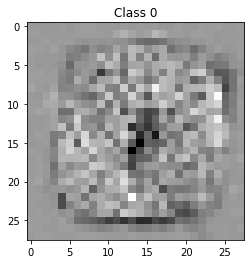

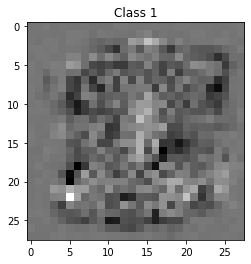

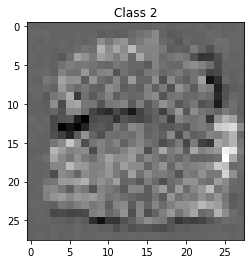

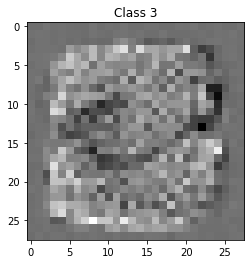

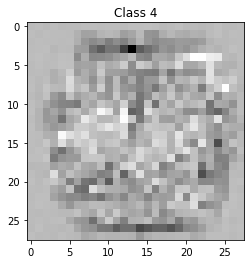

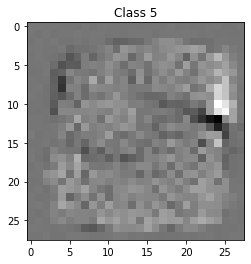

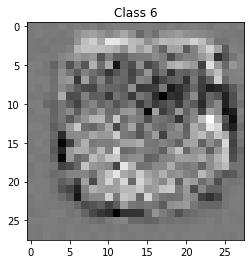

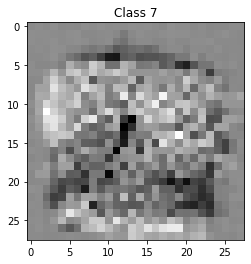

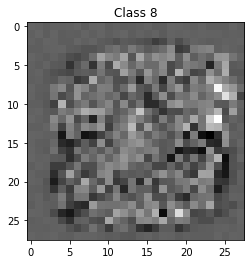

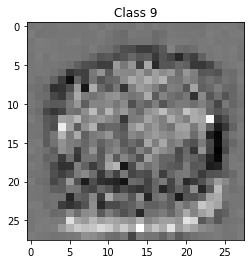

In [23]:
for parameter in network.parameters():
    for i in range(10):
        temp = torchvision.utils.make_grid(parameter[i].resize(28, 28))
        
        temp_np = temp.numpy()
        mx_val = np.amax(temp_np)
        mn_val = np.amin(temp_np)
        
        temp_np -= mn_val
        
        temp_np /= (mx_val - mn_val)
        
        plt.figure()
        plt.title("Class " + str(i))
        plt.imshow(np.transpose(temp_np, (1, 2, 0)))
        plt.show()
    
    break # we only need the first model parameter (weights)

In [24]:
limited_net = Net(num_inputs, num_outputs)
limited_optimizer = optim.SGD(network.parameters(), lr=lr)
# train only on 50 examples

def limited_train(epoch, train_loader):
    limited_net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        if batch_idx >= 50:
            break
        
        data, target = Variable(data), Variable(target)
        limited_optimizer.zero_grad()
        output = limited_net(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        limited_optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def limited_test(test_loader):
    limited_net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = limited_net(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [25]:
# we shall use the same options

for i in range(1, epochs+1):
    limited_train(i, mnist_train_loader)

limited_test(mnist_test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.439418
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.449011
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.539250
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.490293
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.363198
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.386252
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.489954
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.509650
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.517300
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.470012

Test set: Average loss: 2.4885, Accuracy: 939/10000 (9%)



# **Answer (3):**
create needed blocks of code (and results) below

In [26]:
def temp_train(epoch, train_loader):
    '''Trains the data and returns the loss mean for the current epoch'''
    network.train()
    
    loss_epoch = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        
        loss_epoch.append(loss.item())
        
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    loss_mean_epoch = np.mean(loss_epoch)
    return loss_mean_epoch

In [27]:
class MultiLayerNet(nn.Module):
    '''Class for the required CNN in Q3 containing a new hidden layer with 1000 units in it'''
    
    def __init__(self, num_inputs, num_outputs):
        super(MultiLayerNet, self).__init__()
        self.linear1 = nn.Linear(num_inputs, 1000)
        self.linear2 = nn.Linear(1000, num_outputs)

    def forward(self, x):
        x = x.view(-1, num_inputs)
        x = self.linear1(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        return x

In [28]:
lr = 0.01

train_loss_curves = [[], [], [], []]

for i in range(4):
    print("Learning Rate: " + str(lr), end=2*'\n')
    
    network = MultiLayerNet(28 ** 2, 10)
    optimizer = optim.SGD(network.parameters(), lr=lr)
    
    # training the new model with the current learning rate
    
    for j in range(1, epochs+1):
        curr_loss_avg = temp_train(j, mnist_train_loader)
        train_loss_curves[i].append(curr_loss_avg)

    test(mnist_test_loader)
    
    lr *= 10 # updating the learning rate

Learning Rate: 0.01

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.364011
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.167956
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.216270
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.189748
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.054280
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.049335
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.166392
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.119463
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.077167
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.029418
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.999725
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.097747
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.986810
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.101930
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.953908
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.967777
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.013556
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.025975
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.948715
Train Epoch: 2 [57600/60000 (96%)]	Loss: 

Train Epoch: 7 [25600/60000 (43%)]	Loss: 1.038322
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.970135
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.984016
Train Epoch: 7 [44800/60000 (75%)]	Loss: 1.068116
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.032066
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.957564
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.995543
Train Epoch: 8 [6400/60000 (11%)]	Loss: 1.014260
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.960442
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.948376
Train Epoch: 8 [25600/60000 (43%)]	Loss: 1.026055
Train Epoch: 8 [32000/60000 (53%)]	Loss: 1.030756
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.976013
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.936286
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.899860
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.024556
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.932735
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.919629
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.828276
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.921475
Train Epoch:

Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.612675
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.629476
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.619286
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.864890
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.597879
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.670799
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.644951
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.711589
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.662658
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.812864
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.814111
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.834556
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.734598
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.557060
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.721423
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.760959
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.738581
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.915607
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.605835
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.756921
Train Epoch:

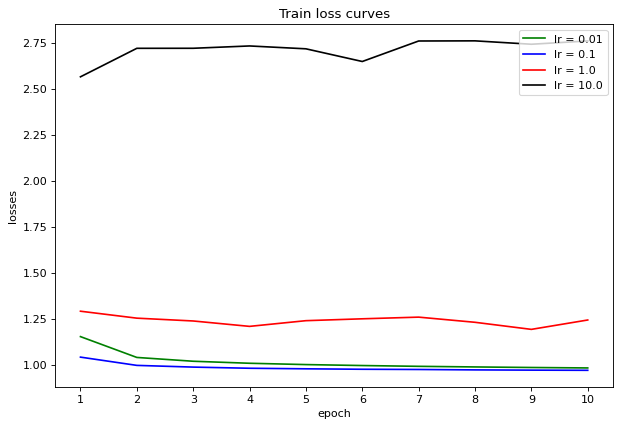

In [29]:
# plotting the loss curves for all four learning rates

colors = ['green', 'blue', 'red', 'black'] # the colors used for different lr in the plot

fg = plt.figure(figsize=(9, 6), dpi=80)
ax = fg.gca()

curr_lr = 0.01

for i in range(4):
    ax.plot(range(1, len(train_loss_curves[i]) + 1), train_loss_curves[i], '-', color=colors[i], label='lr = ' + str(curr_lr))
    curr_lr *= 10

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
plt.title('Train loss curves')

plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(loc="upper right")

plt.show()

# **Answer (4):**
create needed blocks of code (and results) below

In [30]:
dataset = 'cifar10'
lr = 0.01

In [31]:
class ConvNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNet, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        self.conv2 = nn.Conv2d(16, 64, 3, stride=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        
        # linear layers
        self.linear1 = nn.Linear(1600, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.conv3(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [32]:
epochs = 20
network = ConvNet(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.307593
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.285208
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.176691
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.160805
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.016325
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.951250
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.944304
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.074354
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.895839
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.774018
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.890974
Train Epoch: 2 [19200/50000 (38%)]	Loss: 2.013605
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.985365
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.763554
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.789176
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.639143
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.809955
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.787463
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.746599
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.626657
Train Epoch: 3 [25

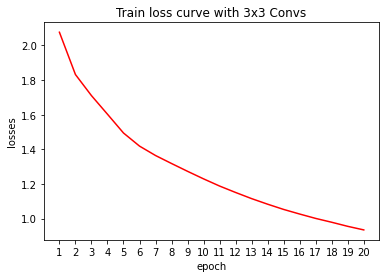

In [33]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve with 3x3 Convs')

plt.show()

In [34]:
class ConvNetWithout3(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_channels=1):
        super(ConvNetWithout3, self).__init__()
        
        # convolution layers
        self.conv1 = nn.Conv2d(num_inputs * num_channels, 16, 5, stride=2)
        
        # linear layers
        self.linear1 = nn.Linear(784, 64)
        self.linear2 = nn.Linear(64, num_outputs)
    
    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x

In [35]:
epochs = 20
network = ConvNetWithout3(num_inputs=1, num_outputs=10, num_channels=3)
optimizer = optim.SGD(network.parameters(), lr=lr)
train_loss_curve = []

# train the new model and save the loss in the above list for the plot

for i in range(1, epochs+1):
    curr_loss_avg = temp_train(i, cifar_train_loader)
    train_loss_curve.append(curr_loss_avg)
    
test(cifar_test_loader)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.324404
Train Epoch: 1 [6400/50000 (13%)]	Loss: 2.156588
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.196345
Train Epoch: 1 [19200/50000 (38%)]	Loss: 2.175187
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.057603
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.011162
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.988255
Train Epoch: 1 [44800/50000 (90%)]	Loss: 2.007997
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.808885
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.798112
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.892272
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.670713
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.536016
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.833655
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.800820
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.634323
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.710251
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.613913
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.586817
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.618343
Train Epoch: 3 [25

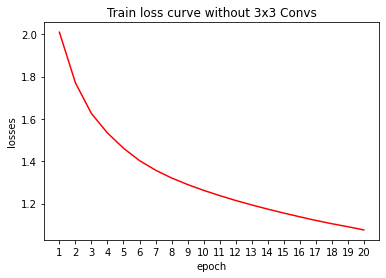

In [36]:
# plotting the loss curve for the training set

fg = plt.figure()
ax = fg.gca()
ax.plot(range(1, len(train_loss_curve) + 1), train_loss_curve, '-', color='red')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Train loss curve without 3x3 Convs')

plt.show()